In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from utils import preprocessing, transforms
from utils.constants import PLOTCOLORS
import matplotlib.pyplot as plt
from scipy import stats

RANDOM_STATE = 21

cwd = Path.cwd()
husky_data = cwd / "norlab-data"
vulpi_data = cwd / "data"
figs_path = cwd / "analysis" / "figs"
figs_path.mkdir(parents=True, exist_ok=True)

COLORS = {
    "base": PLOTCOLORS["dirt road"],
    "ours": PLOTCOLORS["concrete"],
}

In [2]:
# Define channels
columns = {
    "imu": {
        "wx": True,
        "wy": True,
        "wz": True,
        "ax": True,
        "ay": True,
        "az": True,
    },
    "pro": {
        "velL": True,
        "velR": True,
        "curL": True,
        "curR": True,
    },
}
summary = pd.DataFrame({"columns": pd.Series(columns)})

In [3]:
husky_summ = summary.copy()
vulpi_summ = summary.copy()

husky_dfs = preprocessing.get_recordings(husky_data, husky_summ)
vulpi_dfs = preprocessing.get_recordings(vulpi_data, vulpi_summ)

husky_pro = husky_dfs["pro"].copy()
vulpi_pro = vulpi_dfs["pro"].copy()

In [4]:
husky_pro["vx"], husky_pro["wz"] = transforms.unicycle_model(husky_pro)
vulpi_pro["vx"], vulpi_pro["wz"] = transforms.unicycle_model(vulpi_pro)

# Rotationnality

In [5]:
from utils.constants import HuskyConstants

Bs = HuskyConstants.ugv_Bs
husky_pro["rho"] = (
    Bs * husky_pro.wz.abs() / (husky_pro.vx.abs() + Bs * husky_pro.wz.abs())
)
vulpi_pro["rho"] = (
    Bs * vulpi_pro.wz.abs() / (vulpi_pro.vx.abs() + Bs * vulpi_pro.wz.abs())
)

In [6]:
rho_desc = {
    "ours": stats.describe(husky_pro.rho.dropna())._asdict(),
    "baseline": stats.describe(vulpi_pro.rho.dropna())._asdict(),
}
pd.DataFrame.from_dict(rho_desc, orient="index")

,nobs,minmax,mean,variance,skewness,kurtosis
ours,46018,"(0.0, 1.0)",0.417131,0.159803,0.404527,-1.470874
baseline,12319,"(0.0, 1.0)",0.010497,0.003549,9.200214,108.633023


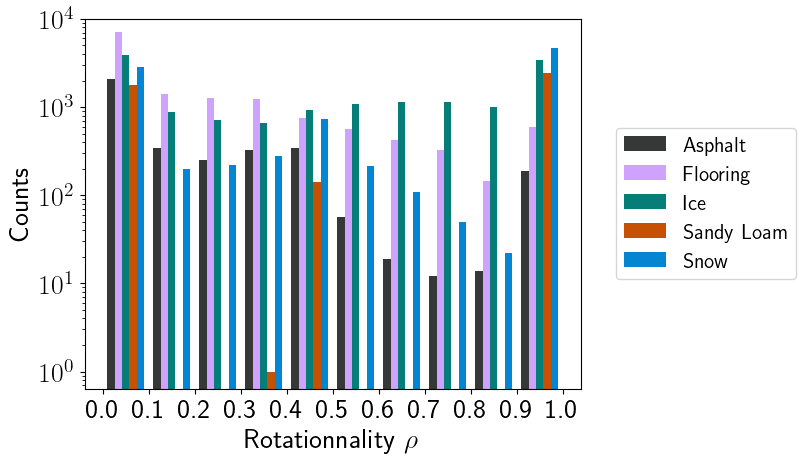

In [15]:
with plt.style.context("./analysis/figure.mplstyle"):
    fig, ax = plt.subplots()

    terrains = sorted(husky_pro.terrain.unique())
    rhos = [husky_pro[husky_pro.terrain == terr].rho for terr in terrains]
    labels = [lab.replace("_", " ").title() for lab in terrains]
    cols = [PLOTCOLORS[lab.lower()] for lab in labels]

    # for rho, lab, col in zip(rhos, labels, cols):
    #     rho.plot.kde(color=col, label=lab, ax=ax)

    ax.hist(
        rhos,
        label=labels,
        color=cols,
        log=True,
    )
    ax.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
    ax.set_xlabel("Rotationnality $\\rho$")
    ax.set_ylabel("Counts")
    ticks = np.round(0.1 * np.arange(11), 1)
    ax.set_xticks(ticks, ticks)
    # ax.set_xlim((0, 1))
    ax.set_ylim(top=1e4)

    fig.savefig(figs_path / "rho-husky.jpg", bbox_inches="tight")
plt.show()

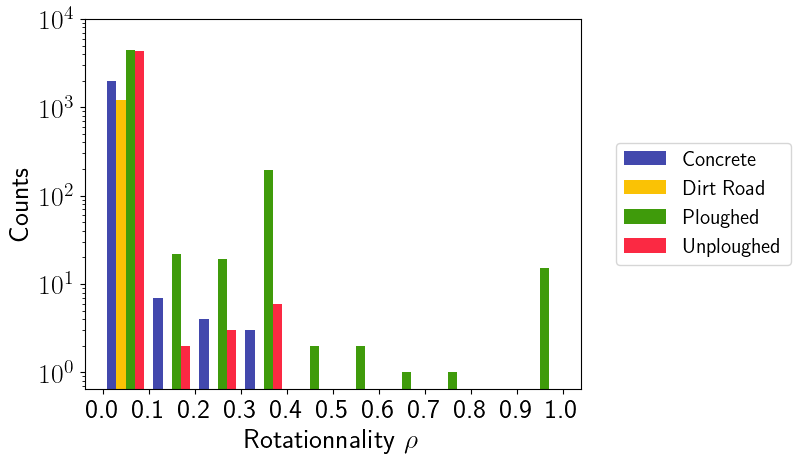

In [8]:
with plt.style.context("./analysis/figure.mplstyle"):
    fig, ax = plt.subplots()

    terrains = sorted(vulpi_pro.terrain.unique())
    rhos = [vulpi_pro[vulpi_pro.terrain == terr].rho for terr in terrains]
    labels = [lab.replace("_", " ").title() for lab in terrains]
    cols = [PLOTCOLORS[lab.lower()] for lab in labels]

    ax.hist(
        rhos,
        label=labels,
        color=cols,
        log=True,
        bins=10,
    )
    ax.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
    ax.set_xlabel("Rotationnality $\\rho$")
    ax.set_ylabel("Counts")
    ticks = np.round(0.1 * np.arange(11), 1)
    ax.set_xticks(ticks, ticks)
    ax.set_ylim(top=1e4)

    fig.savefig(figs_path / "rho-vulpi.jpg", bbox_inches="tight")
plt.show()